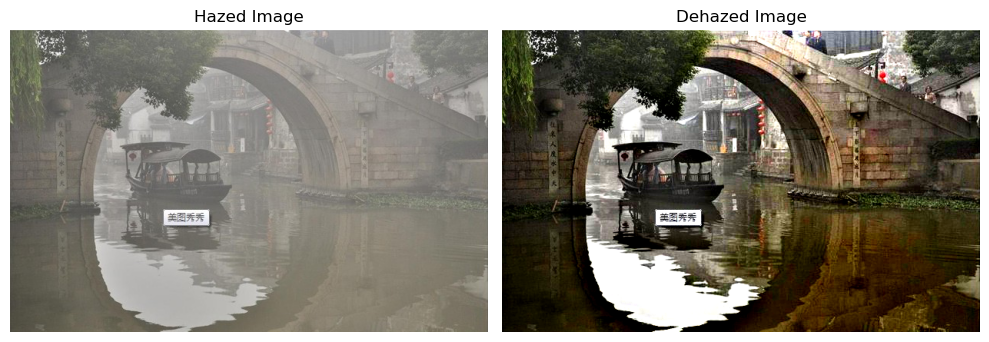

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel(im, size):
    if len(im.shape) == 2:  # If the image is single-channel
        dc = im.copy()
    else:
        b, g, r = cv2.split(im)
        dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(dc, kernel)

def atmospheric_light(im, dc):
    flat = dc.reshape(dc.shape[0] * dc.shape[1])
    flat = np.argsort(flat)
    idx = flat[int(len(flat) * 0.95)]
    return im[idx // im.shape[1], idx % im.shape[1]]

def transmission_estimate(im, al, size, omega, t0):
    t_b = 1 - omega * dark_channel(im[:, :, 0] / al[0], size)
    t_g = 1 - omega * dark_channel(im[:, :, 1] / al[1], size)
    t_r = 1 - omega * dark_channel(im[:, :, 2] / al[2], size)
    return cv2.min(cv2.min(t_b, t_g), t_r)

def guided_filter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    return mean_a * im + mean_b

def recover(im, t, al, t0):
    res = np.empty_like(im)
    for ind in range(3):
        res[:, :, ind] = ((im[:, :, ind] - al[ind]) / cv2.max(t, t0)) + al[ind]
    return res

def dehaze(image, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    dc = dark_channel(image, win_size)
    al = atmospheric_light(image, dc)
    transmission = transmission_estimate(image, al, win_size, omega, t0)
    refined_t = guided_filter(dark_channel(image, 15), transmission, 60, eps)
    result = recover(image.astype(np.float64), refined_t, al, t0)
    return np.uint8(np.clip(result, 0, 255))

# Read the input image
input_image = cv2.imread('./1.jpg')  

# Apply de-hazing
dehazed_image = dehaze(input_image)

# Display hazed and dehazed images side by side
plt.figure(figsize=(10, 5))

# Convert BGR images to RGB for display with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
dehazed_image_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title('Hazed Image')
plt.imshow(input_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dehazed Image')
plt.imshow(dehazed_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

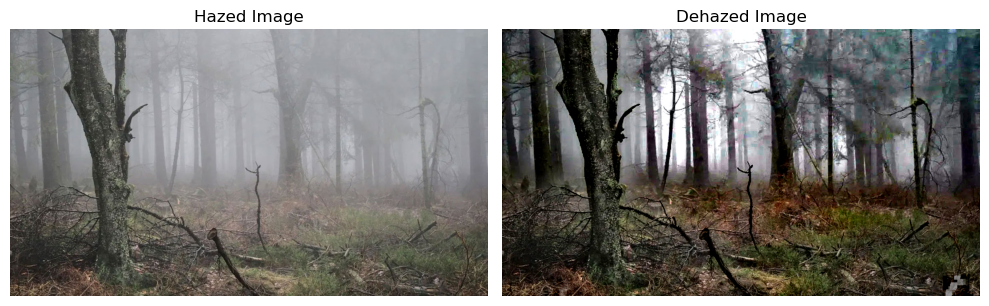

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel(im, size):
    if len(im.shape) == 2:  # If the image is single-channel
        dc = im.copy()
    else:
        b, g, r = cv2.split(im)
        dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(dc, kernel)

def atmospheric_light(im, dc):
    flat = dc.reshape(dc.shape[0] * dc.shape[1])
    flat = np.argsort(flat)
    idx = flat[int(len(flat) * 0.95)]
    return im[idx // im.shape[1], idx % im.shape[1]]

def transmission_estimate(im, al, size, omega, t0):
    t_b = 1 - omega * dark_channel(im[:, :, 0] / al[0], size)
    t_g = 1 - omega * dark_channel(im[:, :, 1] / al[1], size)
    t_r = 1 - omega * dark_channel(im[:, :, 2] / al[2], size)
    return cv2.min(cv2.min(t_b, t_g), t_r)

def guided_filter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    return mean_a * im + mean_b

def recover(im, t, al, t0):
    res = np.empty_like(im)
    for ind in range(3):
        res[:, :, ind] = ((im[:, :, ind] - al[ind]) / cv2.max(t, t0)) + al[ind]
    return res

def dehaze(image, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    dc = dark_channel(image, win_size)
    al = atmospheric_light(image, dc)
    transmission = transmission_estimate(image, al, win_size, omega, t0)
    refined_t = guided_filter(dark_channel(image, 15), transmission, 60, eps)
    result = recover(image.astype(np.float64), refined_t, al, t0)
    return np.uint8(np.clip(result, 0, 255))

# Read the input image
input_image = cv2.imread('./2.jpg')  

# Apply de-hazing
dehazed_image = dehaze(input_image)

# Display hazed and dehazed images side by side
plt.figure(figsize=(10, 5))

# Convert BGR images to RGB for display with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
dehazed_image_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title('Hazed Image')
plt.imshow(input_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dehazed Image')
plt.imshow(dehazed_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

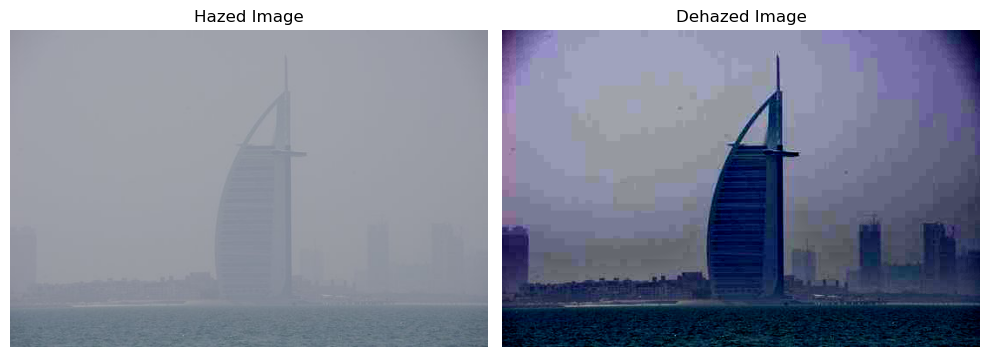

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel(im, size):
    if len(im.shape) == 2:  # If the image is single-channel
        dc = im.copy()
    else:
        b, g, r = cv2.split(im)
        dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(dc, kernel)

def atmospheric_light(im, dc):
    flat = dc.reshape(dc.shape[0] * dc.shape[1])
    flat = np.argsort(flat)
    idx = flat[int(len(flat) * 0.95)]
    return im[idx // im.shape[1], idx % im.shape[1]]

def transmission_estimate(im, al, size, omega, t0):
    t_b = 1 - omega * dark_channel(im[:, :, 0] / al[0], size)
    t_g = 1 - omega * dark_channel(im[:, :, 1] / al[1], size)
    t_r = 1 - omega * dark_channel(im[:, :, 2] / al[2], size)
    return cv2.min(cv2.min(t_b, t_g), t_r)

def guided_filter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    return mean_a * im + mean_b

def recover(im, t, al, t0):
    res = np.empty_like(im)
    for ind in range(3):
        res[:, :, ind] = ((im[:, :, ind] - al[ind]) / cv2.max(t, t0)) + al[ind]
    return res

def dehaze(image, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    dc = dark_channel(image, win_size)
    al = atmospheric_light(image, dc)
    transmission = transmission_estimate(image, al, win_size, omega, t0)
    refined_t = guided_filter(dark_channel(image, 15), transmission, 60, eps)
    result = recover(image.astype(np.float64), refined_t, al, t0)
    return np.uint8(np.clip(result, 0, 255))

# Read the input image
input_image = cv2.imread('./3.jpg')  

# Apply de-hazing
dehazed_image = dehaze(input_image)

# Display hazed and dehazed images side by side
plt.figure(figsize=(10, 5))

# Convert BGR images to RGB for display with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
dehazed_image_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title('Hazed Image')
plt.imshow(input_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dehazed Image')
plt.imshow(dehazed_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

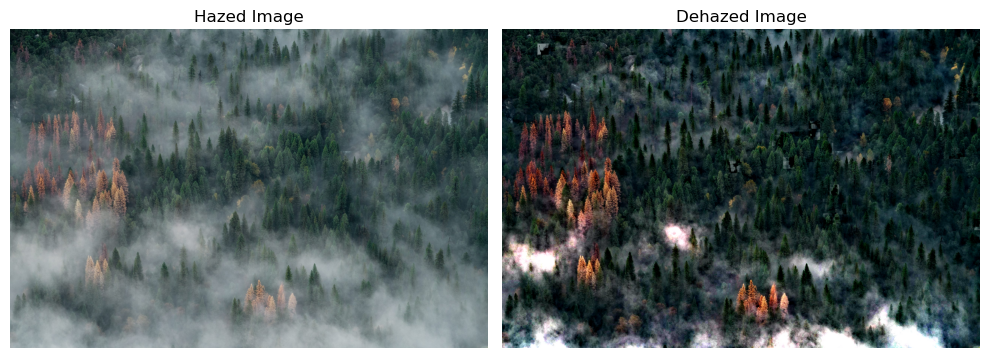

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel(im, size):
    if len(im.shape) == 2:  # If the image is single-channel
        dc = im.copy()
    else:
        b, g, r = cv2.split(im)
        dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(dc, kernel)

def atmospheric_light(im, dc):
    flat = dc.reshape(dc.shape[0] * dc.shape[1])
    flat = np.argsort(flat)
    idx = flat[int(len(flat) * 0.95)]
    return im[idx // im.shape[1], idx % im.shape[1]]

def transmission_estimate(im, al, size, omega, t0):
    t_b = 1 - omega * dark_channel(im[:, :, 0] / al[0], size)
    t_g = 1 - omega * dark_channel(im[:, :, 1] / al[1], size)
    t_r = 1 - omega * dark_channel(im[:, :, 2] / al[2], size)
    return cv2.min(cv2.min(t_b, t_g), t_r)

def guided_filter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    return mean_a * im + mean_b

def recover(im, t, al, t0):
    res = np.empty_like(im)
    for ind in range(3):
        res[:, :, ind] = ((im[:, :, ind] - al[ind]) / cv2.max(t, t0)) + al[ind]
    return res

def dehaze(image, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    dc = dark_channel(image, win_size)
    al = atmospheric_light(image, dc)
    transmission = transmission_estimate(image, al, win_size, omega, t0)
    refined_t = guided_filter(dark_channel(image, 15), transmission, 60, eps)
    result = recover(image.astype(np.float64), refined_t, al, t0)
    return np.uint8(np.clip(result, 0, 255))

# Read the input image
input_image = cv2.imread('./4.jpg')  

# Apply de-hazing
dehazed_image = dehaze(input_image)

# Display hazed and dehazed images side by side
plt.figure(figsize=(10, 5))

# Convert BGR images to RGB for display with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
dehazed_image_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title('Hazed Image')
plt.imshow(input_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dehazed Image')
plt.imshow(dehazed_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

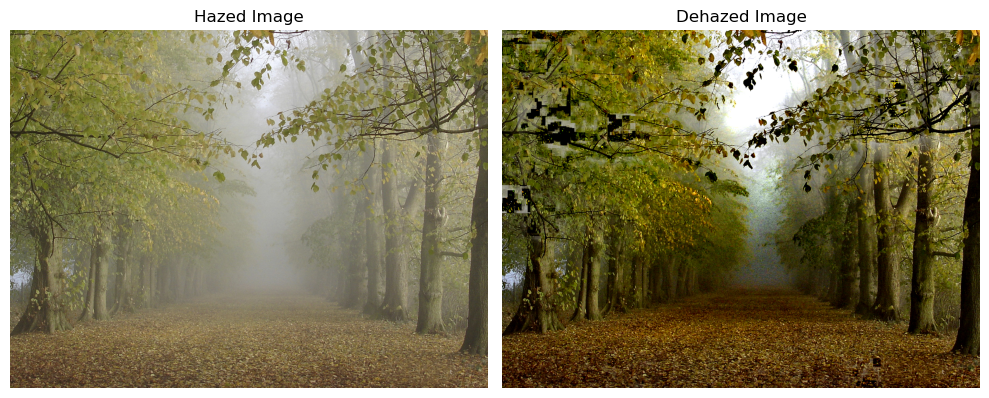

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel(im, size):
    if len(im.shape) == 2:  # If the image is single-channel
        dc = im.copy()
    else:
        b, g, r = cv2.split(im)
        dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(dc, kernel)

def atmospheric_light(im, dc):
    flat = dc.reshape(dc.shape[0] * dc.shape[1])
    flat = np.argsort(flat)
    idx = flat[int(len(flat) * 0.95)]
    return im[idx // im.shape[1], idx % im.shape[1]]

def transmission_estimate(im, al, size, omega, t0):
    t_b = 1 - omega * dark_channel(im[:, :, 0] / al[0], size)
    t_g = 1 - omega * dark_channel(im[:, :, 1] / al[1], size)
    t_r = 1 - omega * dark_channel(im[:, :, 2] / al[2], size)
    return cv2.min(cv2.min(t_b, t_g), t_r)

def guided_filter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    return mean_a * im + mean_b

def recover(im, t, al, t0):
    res = np.empty_like(im)
    for ind in range(3):
        res[:, :, ind] = ((im[:, :, ind] - al[ind]) / cv2.max(t, t0)) + al[ind]
    return res

def dehaze(image, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    dc = dark_channel(image, win_size)
    al = atmospheric_light(image, dc)
    transmission = transmission_estimate(image, al, win_size, omega, t0)
    refined_t = guided_filter(dark_channel(image, 15), transmission, 60, eps)
    result = recover(image.astype(np.float64), refined_t, al, t0)
    return np.uint8(np.clip(result, 0, 255))

# Read the input image
input_image = cv2.imread('./6.jpg')  

# Apply de-hazing
dehazed_image = dehaze(input_image)

# Display hazed and dehazed images side by side
plt.figure(figsize=(10, 5))

# Convert BGR images to RGB for display with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
dehazed_image_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title('Hazed Image')
plt.imshow(input_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dehazed Image')
plt.imshow(dehazed_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

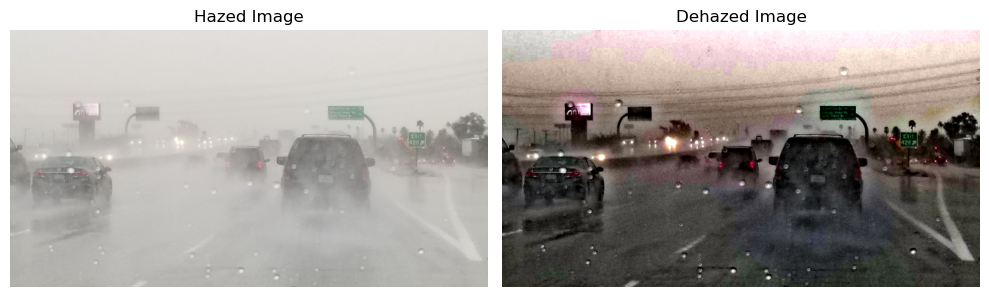

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel(im, size):
    if len(im.shape) == 2:  # If the image is single-channel
        dc = im.copy()
    else:
        b, g, r = cv2.split(im)
        dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(dc, kernel)

def atmospheric_light(im, dc):
    flat = dc.reshape(dc.shape[0] * dc.shape[1])
    flat = np.argsort(flat)
    idx = flat[int(len(flat) * 0.95)]
    return im[idx // im.shape[1], idx % im.shape[1]]

def transmission_estimate(im, al, size, omega, t0):
    t_b = 1 - omega * dark_channel(im[:, :, 0] / al[0], size)
    t_g = 1 - omega * dark_channel(im[:, :, 1] / al[1], size)
    t_r = 1 - omega * dark_channel(im[:, :, 2] / al[2], size)
    return cv2.min(cv2.min(t_b, t_g), t_r)

def guided_filter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    return mean_a * im + mean_b

def recover(im, t, al, t0):
    res = np.empty_like(im)
    for ind in range(3):
        res[:, :, ind] = ((im[:, :, ind] - al[ind]) / cv2.max(t, t0)) + al[ind]
    return res

def dehaze(image, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    dc = dark_channel(image, win_size)
    al = atmospheric_light(image, dc)
    transmission = transmission_estimate(image, al, win_size, omega, t0)
    refined_t = guided_filter(dark_channel(image, 15), transmission, 60, eps)
    result = recover(image.astype(np.float64), refined_t, al, t0)
    return np.uint8(np.clip(result, 0, 255))

# Read the input image
input_image = cv2.imread('./5.jpg')  

# Apply de-hazing
dehazed_image = dehaze(input_image)

# Display hazed and dehazed images side by side
plt.figure(figsize=(10, 5))

# Convert BGR images to RGB for display with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
dehazed_image_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title('Hazed Image')
plt.imshow(input_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dehazed Image')
plt.imshow(dehazed_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

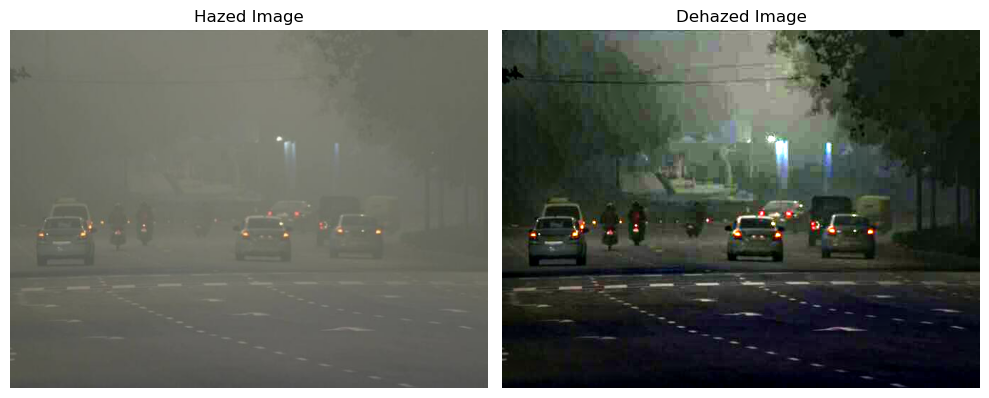

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel(im, size):
    if len(im.shape) == 2:  # If the image is single-channel
        dc = im.copy()
    else:
        b, g, r = cv2.split(im)
        dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(dc, kernel)

def atmospheric_light(im, dc):
    flat = dc.reshape(dc.shape[0] * dc.shape[1])
    flat = np.argsort(flat)
    idx = flat[int(len(flat) * 0.95)]
    return im[idx // im.shape[1], idx % im.shape[1]]

def transmission_estimate(im, al, size, omega, t0):
    t_b = 1 - omega * dark_channel(im[:, :, 0] / al[0], size)
    t_g = 1 - omega * dark_channel(im[:, :, 1] / al[1], size)
    t_r = 1 - omega * dark_channel(im[:, :, 2] / al[2], size)
    return cv2.min(cv2.min(t_b, t_g), t_r)

def guided_filter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    return mean_a * im + mean_b

def recover(im, t, al, t0):
    res = np.empty_like(im)
    for ind in range(3):
        res[:, :, ind] = ((im[:, :, ind] - al[ind]) / cv2.max(t, t0)) + al[ind]
    return res

def dehaze(image, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    dc = dark_channel(image, win_size)
    al = atmospheric_light(image, dc)
    transmission = transmission_estimate(image, al, win_size, omega, t0)
    refined_t = guided_filter(dark_channel(image, 15), transmission, 60, eps)
    result = recover(image.astype(np.float64), refined_t, al, t0)
    return np.uint8(np.clip(result, 0, 255))

# Read the input image
input_image = cv2.imread('./35.jpg')  

# Apply de-hazing
dehazed_image = dehaze(input_image)

# Display hazed and dehazed images side by side
plt.figure(figsize=(10, 5))

# Convert BGR images to RGB for display with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
dehazed_image_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title('Hazed Image')
plt.imshow(input_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dehazed Image')
plt.imshow(dehazed_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def dark_channel(im, size):
    if len(im.shape) == 2:  # If the image is single-channel
        dc = im.copy()
    else:
        b, g, r = cv2.split(im)
        dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(dc, kernel)

def atmospheric_light(im, dc):
    flat = dc.reshape(dc.shape[0] * dc.shape[1])
    flat = np.argsort(flat)
    idx = flat[int(len(flat) * 0.95)]
    return im[idx // im.shape[1], idx % im.shape[1]]

def transmission_estimate(im, al, size, omega, t0):
    t_b = 1 - omega * dark_channel(im[:, :, 0] / al[0], size)
    t_g = 1 - omega * dark_channel(im[:, :, 1] / al[1], size)
    t_r = 1 - omega * dark_channel(im[:, :, 2] / al[2], size)
    return cv2.min(cv2.min(t_b, t_g), t_r)

def guided_filter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    return mean_a * im + mean_b

def recover(im, t, al, t0):
    res = np.empty_like(im)
    for ind in range(3):
        res[:, :, ind] = ((im[:, :, ind] - al[ind]) / cv2.max(t, t0)) + al[ind]
    return res

def dehaze(image, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    dc = dark_channel(image, win_size)
    al = atmospheric_light(image, dc)
    transmission = transmission_estimate(image, al, win_size, omega, t0)
    refined_t = guided_filter(dark_channel(image, 15), transmission, 60, eps)
    result = recover(image.astype(np.float64), refined_t, al, t0)
    return np.uint8(np.clip(result, 0, 255))

# Read the input image
input_image = cv2.imread('./34.jpg')  

# Apply de-hazing
dehazed_image = dehaze(input_image)

# Display hazed and dehazed images side by side
plt.figure(figsize=(10, 5))

# Convert BGR images to RGB for display with matplotlib
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
dehazed_image_rgb = cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB)

plt.subplot(1, 2, 1)
plt.title('Hazed Image')
plt.imshow(input_image_rgb)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Dehazed Image')
plt.imshow(dehazed_image_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import subprocess

def dark_channel(im, size):
    if len(im.shape) == 2:  # If the image is single-channel
        dc = im.copy()
    else:
        b, g, r = cv2.split(im)
        dc = cv2.min(cv2.min(r, g), b)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (size, size))
    return cv2.erode(dc, kernel)

def atmospheric_light(im, dc):
    flat = dc.reshape(dc.shape[0] * dc.shape[1])
    flat = np.argsort(flat)
    idx = flat[int(len(flat) * 0.95)]
    return im[idx // im.shape[1], idx % im.shape[1]]

def transmission_estimate(im, al, size, omega, t0):
    t_b = 1 - omega * dark_channel(im[:, :, 0] / al[0], size)
    t_g = 1 - omega * dark_channel(im[:, :, 1] / al[1], size)
    t_r = 1 - omega * dark_channel(im[:, :, 2] / al[2], size)
    return cv2.min(cv2.min(t_b, t_g), t_r)

def guided_filter(im, p, r, eps):
    mean_I = cv2.boxFilter(im, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    mean_Ip = cv2.boxFilter(im * p, cv2.CV_64F, (r, r))
    cov_Ip = mean_Ip - mean_I * mean_p

    mean_II = cv2.boxFilter(im * im, cv2.CV_64F, (r, r))
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    return mean_a * im + mean_b

def recover(im, t, al, t0):
    res = np.empty_like(im)
    for ind in range(3):
        res[:, :, ind] = ((im[:, :, ind] - al[ind]) / cv2.max(t, t0)) + al[ind]
    return res
def dehaze(image, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    dc = dark_channel(image, win_size)
    al = atmospheric_light(image, dc)
    transmission = transmission_estimate(image, al, win_size, omega, t0)
    refined_t = guided_filter(dark_channel(image, 15), transmission, 60, eps)
    result = recover(image.astype(np.float64), refined_t, al, t0)
    return np.uint8(np.clip(result, 0, 255))
def dehaze_video(input_video_path, output_video_path, omega=0.95, win_size=15, eps=0.001, t0=0.1):
    cap = cv2.VideoCapture(input_video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get the video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    frame_count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Apply dehazing to the frame
        dehazed_frame = dehaze(frame, omega, win_size, eps, t0)

        # Write the dehazed frame to the output video
        out.write(dehazed_frame)

        frame_count += 1
        print(f"Processed frame {frame_count}/{num_frames}")

        if frame_count == num_frames:  # Processed all frames
            break

    # Release resources
    cap.release()
    out.release()

    print("Dehazing complete. Output video saved at:", output_video_path)

input_video_path = './test.mp4'  
output_video_path = 'ded_output.avi'  


dehaze_video(input_video_path, output_video_path)

Processed frame 1/15
Processed frame 2/15
Processed frame 3/15
Processed frame 4/15
Processed frame 5/15
Processed frame 6/15
Processed frame 7/15
Processed frame 8/15
Processed frame 9/15
Processed frame 10/15
Processed frame 11/15
Processed frame 12/15
Processed frame 13/15
Processed frame 14/15
Processed frame 15/15
Dehazing complete. Output video saved at: ded_output.avi


In [22]:
import pickle

# Load the functions from the file
with open('model.pkl', 'rb') as file:
    loaded_functions_dict = pickle.load(file)

# Now you can use the loaded functions
loaded_dehaze_video = loaded_functions_dict['dehaze_video']

input_video_path = './test.mp4'
output_video_path = '.result/maii.avi'

loaded_dehaze_video(input_video_path, output_video_path)


Processed frame 1/15
Processed frame 2/15
Processed frame 3/15
Processed frame 4/15
Processed frame 5/15
Processed frame 6/15
Processed frame 7/15
Processed frame 8/15
Processed frame 9/15
Processed frame 10/15
Processed frame 11/15
Processed frame 12/15
Processed frame 13/15
Processed frame 14/15
Processed frame 15/15
Dehazing complete. Output video saved at: .result/maii.avi


In [17]:
import pickle

functions_dict = {
    'dark_channel': dark_channel,
    'atmospheric_light': atmospheric_light,
    'transmission_estimate': transmission_estimate,
    'guided_filter': guided_filter,
    'recover': recover,
    'dehaze':dehaze,
    'dehaze_video': dehaze_video
}

# Save the functions dictionary to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(functions_dict, file)
